In [ ]:
# print(torch.__version__)
# !nvidia-smi
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install class_resolver

In [ ]:
import torch

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print("device: {}".format(device))

In [ ]:
RANDOM_SEED = 42

In [ ]:
from scipy.io import loadmat
import numpy as np
data = loadmat('/content/pyg_data/qm7/raw/qm7.mat')
y = np.transpose(data['T']).reshape((7165,))
y_scaling_factor = np.max(np.absolute(y))

In [ ]:
from torch_geometric.data import Data, InMemoryDataset, download_url

# Modified from original QM7b loader from PyG
class QM7(InMemoryDataset):
    r"""
    Args:
        root (string): Root directory where the dataset should be saved.
        transform (callable, optional): A function/transform that takes in an
            :obj:`torch_geometric.data.Data` object and returns a transformed
            version. The data object will be transformed before every access.
            (default: :obj:`None`)
        pre_transform (callable, optional): A function/transform that takes in
            an :obj:`torch_geometric.data.Data` object and returns a
            transformed version. The data object will be transformed before
            being saved to disk. (default: :obj:`None`)
        pre_filter (callable, optional): A function that takes in an
            :obj:`torch_geometric.data.Data` object and returns a boolean
            value, indicating whether the data object should be included in the
            final dataset. (default: :obj:`None`)
    """

    url = 'http://www.quantum-machine.org/data/qm7.mat'

    def __init__(self, root, transform=None, pre_transform=None,
                 pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return 'qm7.mat'

    @property
    def processed_file_names(self):
        return 'data.pt'

    def download(self):
        download_url(self.url, self.raw_dir)

    def process(self):
        data = loadmat(self.raw_paths[0])
        coulomb_matrix = torch.from_numpy(data['X'])
        y = np.transpose(data['T']).reshape((7165,))
        y_scaling_factor = np.max(np.absolute(y))
        y_scaled = y/y_scaling_factor
        target = torch.from_numpy(y_scaled).to(torch.float)

        data_list = []
        for i in range(target.shape[0]):
            edge_index = coulomb_matrix[i].nonzero(as_tuple=False).t().contiguous()
            edge_attr = coulomb_matrix[i, edge_index[0], edge_index[1]]
            diag = torch.diagonal(coulomb_matrix[i], 0)
            x = diag[diag.nonzero(as_tuple=False).t().contiguous()].flatten()
            y = target[i].view(1, -1)
            data = Data(x=torch.reshape(x, ((list(x.size()))[0], 1)), edge_index=edge_index, edge_attr=edge_attr, y=y)
            data.num_nodes = edge_index.max().item() + 1
            data.num_node_features = 1
            data.num_edge_features = 1
            data_list.append(data)

        if self.pre_filter is not None:
            data_list = [d for d in data_list if self.pre_filter(d)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(d) for d in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [ ]:
dataset = QM7(root='pyg_data/qm7')

print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

# data = loadmat('pyg_data/qm7/raw/qm7.mat')
# y = np.transpose(data['T']).reshape((7165,))
# y_scaling_factor = np.max(np.absolute(y))
# y_scaled = y/y_scaling_factor
# print("unique labels: {}".format(np.unique(y_scaled).shape))

Dataset: QM7(7165):
Number of graphs: 7165
Number of features: 1
Number of classes: 6789

Data(x=[5, 1], edge_index=[2, 25], edge_attr=[25], y=[1, 1], num_node_features=[1], num_edge_features=[1], num_nodes=5)
Number of nodes: 5
Number of edges: 25
Average node degree: 5.00
Has isolated nodes: False
Has self-loops: True
Is undirected: True


In [ ]:
# Define GNN
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        torch.manual_seed(RANDOM_SEED)
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, 8)
        self.conv3 = GCNConv(8, 4)
        self.lin = Linear(4, 1)

    def forward(self, x, edge_index, edge_attr, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_attr)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_attr)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = self.lin(x)
        
        return x

model = GNN().to(device)
print(model)

GNN(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 8)
  (conv3): GCNConv(8, 4)
  (lin): Linear(in_features=4, out_features=1, bias=True)
)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.L1Loss()

NUM_EPOCHS = 200

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        # Load data to GPU
        data.x = data.x.to(device)
        data.edge_index = data.edge_index.to(device)
        data.edge_attr = data.edge_attr.to(device)
        data.batch = data.batch.to(device)
        data.y = data.y.to(device)
        data.ptr = data.ptr.to(device)

        out = model(data.x, data.edge_index, data.edge_attr, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(loader):
    model.eval()
    err = 0
    for data in loader:
        data.x = data.x.to(device)
        data.edge_index = data.edge_index.to(device)
        data.edge_attr = data.edge_attr.to(device)
        data.batch = data.batch.to(device)
        data.y = data.y.to(device)
        data.ptr = data.ptr.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        err += torch.mean(torch.abs(out - data.y)).item()
    return err

In [ ]:
# Splitting training set and testing set

torch.manual_seed(RANDOM_SEED)
dataset = dataset.shuffle()

test_dataset = dataset[7000:]
train_dataset = dataset[:7000]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

# DataLoader

from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Setting console display

from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Train GNN

history_train_loss = []
history_test_loss = []
for epoch in range(NUM_EPOCHS):
    train()
    train_loss = test(train_loader)
    test_loss = test(test_loader)
    print("Epoch: {}, Train Loss: {}, Test Loss: {}".format(epoch+1, train_loss, test_loss))
    history_train_loss.append(train_loss*y_scaling_factor)
    history_test_loss.append(test_loss*y_scaling_factor)

Number of training graphs: 7000
Number of test graphs: 165


<IPython.core.display.Javascript object>

Epoch: 1, Train Loss: 4.000153513625264, Test Loss: 0.09880124777555466
Epoch: 2, Train Loss: 3.8005808386951685, Test Loss: 0.10020285099744797
Epoch: 3, Train Loss: 4.370988950133324, Test Loss: 0.1221449263393879
Epoch: 4, Train Loss: 3.8269260060042143, Test Loss: 0.09631717205047607
Epoch: 5, Train Loss: 4.250787304714322, Test Loss: 0.11198587715625763
Epoch: 6, Train Loss: 3.7303193509578705, Test Loss: 0.0980997271835804
Epoch: 7, Train Loss: 3.9250837676227093, Test Loss: 0.10351412370800972
Epoch: 8, Train Loss: 3.7909499518573284, Test Loss: 0.09513376653194427
Epoch: 9, Train Loss: 3.7678901478648186, Test Loss: 0.09834731929004192
Epoch: 10, Train Loss: 3.737769180908799, Test Loss: 0.09838984161615372
Epoch: 11, Train Loss: 4.70332488976419, Test Loss: 0.11806625127792358
Epoch: 12, Train Loss: 3.810503927990794, Test Loss: 0.09321239590644836
Epoch: 13, Train Loss: 3.669619919732213, Test Loss: 0.09471920132637024
Epoch: 14, Train Loss: 3.7335624247789383, Test Loss: 0.0

No handles with labels found to put in legend.


Final train loss: 7514.09451174736
Final test loss: 193.37611338496208


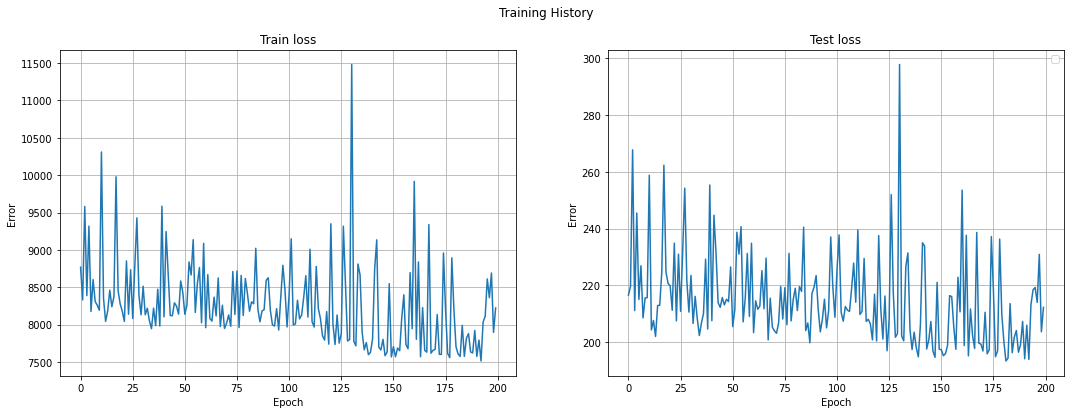

In [ ]:
# Performance
print("Final train loss: {}".format(min(history_train_loss)))
print("Final test loss: {}".format(min(history_test_loss)))

from matplotlib import pyplot as plt

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Training History')
ax1.plot(history_train_loss)
ax1.set_title("Train loss")
ax2.plot(history_test_loss)
ax2.set_title("Test loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Error')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Error')
plt.legend()
ax1.grid(True)
ax2.grid(True)